In [1]:
# script to run simulations of stream peppering
import os, os.path
import csv
import time
import pickle
import matplotlib
#matplotlib.use('agg')
import numpy
from scipy import integrate, interpolate
from optparse import OptionParser
from galpy.util import bovy_conversion
import gd1_util
import pal5_util
from gd1_util import R0,V0
from scipy.integrate import quad
from scipy.optimize import brentq
import GMC_GC_util
import glob
from galpy.util import bovy_conversion, bovy_coords, save_pickles, bovy_plot
from galpy.potential import MWPotential2014, turn_physical_off, vcirc
import astropy.units as u
%pylab inline
from galpy.orbit import Orbit
from scipy import ndimage, signal, interpolate
from numpy.polynomial import Polynomial
from gd1_util_MWhaloshape import lb_to_phi12

Populating the interactive namespace from numpy and matplotlib


In [2]:
#All the functions
def compute_obs_density(phi1,apars,dens_apar,Omega):
    
    apar_edge=[]
    phi1_edge=[]

    abw0=apars[1]-apars[0]
    apar_edge.append(apars[0]-(abw0/2.))

    phi1bw0=phi1[1]-phi1[0]
    phi1_edge.append(phi1[0]-(phi1bw0/2.))

    for ii in range(len(apars)-1):
        abw=apars[ii+1]-apars[ii]
        phi1bw=phi1[ii+1]-phi1[ii]
        apar_edge.append(apars[ii]+abw/2.)
        phi1_edge.append(phi1[ii]+phi1bw/2.)

    abw_last=apars[len(apars)-1]-apars[len(apars)-2]
    apar_edge.append(apars[len(apars)-1]+(abw_last/2.))

    phi1bw_last=phi1[len(phi1)-1]-phi1[len(phi1)-2]
    phi1_edge.append(phi1[len(phi1)-1]+(phi1bw_last/2.))

    #compute the Jacobian d(apar)/d(phi1) using finite difference method
    dapar_dphi1=np.fabs(numpy.diff(apar_edge)/numpy.diff(phi1_edge))
    #print (dapar_dphi1)
   
    #Interpolate dens(apar)
    ipdens_apar= interpolate.InterpolatedUnivariateSpline(apars,dens_apar)

    #Interpolate apar(phi1)
    if phi1[1] < phi1[0] : # ad-hoc way of checking whether increasing or decreasing
        ipphi1= interpolate.InterpolatedUnivariateSpline(phi1[::-1],apars[::-1])
        #Interpolate Jacobian
        ipdapar_dphi1=interpolate.InterpolatedUnivariateSpline(phi1[::-1],dapar_dphi1[::-1])
        #Interpolate density(phi1) by multiplying by jacobian
        dens_phi1=interpolate.InterpolatedUnivariateSpline(phi1[::-1],ipdens_apar(ipphi1(phi1[::-1]))*ipdapar_dphi1(phi1[::-1]))
        
    else :
        ipphi1= interpolate.InterpolatedUnivariateSpline(phi1,apars)
        #Interpolate Jacobian
        ipdapar_dphi1=interpolate.InterpolatedUnivariateSpline(phi1,dapar_dphi1)
        #Interpolate density(phi1) by multiplying by jacobian
        dens_phi1=interpolate.InterpolatedUnivariateSpline(phi1,ipdens_apar(ipphi1(phi1))*ipdapar_dphi1(phi1))
       
    return (dens_phi1(phi1))

def get_data(arm='trailing',poly_deg=3,gap_width=12.):
    
    #load's deBoer's data after selecting between phi1_min and phi1_max
    #
    gaia_dat=np.genfromtxt('fromDenis/GD1_stream_track_density_uncorr.dat',names=True)
    midphi1=gaia_dat['phi1mid']
    lin_den = gaia_dat['lindens']
    elin_den=gaia_dat['e_lindens']
    phi2=gaia_dat['phi2']
    ephi2=gaia_dat['e_phi2']

    print (min(midphi1),max(midphi1))
    
    if arm == 'leading' :
        phi1_min=-60.
        phi1_max=-40 -(gap_width*0.5)  #-42. 
        
    else :
        phi1_min=-40 +(gap_width*0.5) 
        phi1_max=-4. #-4.   
        
    phi1_cut = midphi1[(midphi1 <= phi1_max) & (midphi1 >= phi1_min)]
    lin_den_cut = lin_den[(midphi1 <= phi1_max) & (midphi1 >= phi1_min)]
    elin_den_cut = elin_den[(midphi1 <= phi1_max) & (midphi1 >= phi1_min)]
    phi2_cut = phi2[(midphi1 <= phi1_max) & (midphi1 >= phi1_min)]
    ephi2_cut = ephi2[(midphi1 <= phi1_max) & (midphi1 >= phi1_min)]
    
    #fit 3rd order polynomial
    pp= Polynomial.fit(phi1_cut,lin_den_cut,deg=poly_deg,w=1/(elin_den_cut))  #for linear density
    pp_phi2= Polynomial.fit(phi1_cut,phi2_cut,deg=poly_deg,w=1/(ephi2_cut))   # for track
    
    #normalize density, track and errors
    norm_den = lin_den_cut/pp(phi1_cut)
    norm_den_err = elin_den_cut/pp(phi1_cut)
    norm_phi2_cut= phi2_cut - pp_phi2(phi1_cut)
    
    return (phi1_cut,phi2_cut,norm_den,norm_den_err,norm_phi2_cut,ephi2_cut)  

def compute_length_old(phi1,dens_phi1,arm='trailing',threshold=0.2):
    
    
    if phi1[1] < phi1[0]:
        ip_dens_phi1=interpolate.InterpolatedUnivariateSpline(phi1[::-1],dens_phi1[::-1])
        
    else:
        ip_dens_phi1=interpolate.InterpolatedUnivariateSpline(phi1,dens_phi1)
    
    if arm == 'leading' :     
        mean_den=np.mean(dens_phi1[(phi1 >= -44.) & (phi1 <= -40.)])
        try:
            length=np.abs(-40. - brentq(lambda x: ip_dens_phi1(x)-mean_den*threshold,-60.,max(phi1)))
            
        except ValueError:
            length = -40.-(-60.) # full length
            
            
    else :    
        mean_den=np.mean(dens_phi1[(phi1 >= -40.) & (phi1 <= -36.)])
        try:
            #length=np.abs(min(phi1)-brentq(lambda x: ip_dens_phi1(x)-mean_den*threshold,min(phi1),-4.))
            length=np.abs(-40-brentq(lambda x: ip_dens_phi1(x)-mean_den*threshold,min(phi1),-4.))
            #print (length)
        except ValueError as e:
            #print (e)
            #print (dens_phi1)
            length = -4.-(-40.) # full length
              
    return (length)


def compute_length(phi1_all,dens_phi1_all,arm='trailing',threshold=0.2):
    
      
    if arm == 'leading':
        phi1 = phi1_all[(phi1_all >= -60.) & (phi1_all <= -40.)]
        dens_phi1 = dens_phi1_all[(phi1_all >= -60.) & (phi1_all <= -40.)]
        mean_den=np.mean(dens_phi1[(phi1 >= -44.) & (phi1 <= -40.)])
        
    else :    
        phi1 = phi1_all[(phi1_all >= -40.) & (phi1_all <= -4.)]
        dens_phi1=dens_phi1_all[(phi1_all >= -40.) & (phi1_all <= -4.)]
        mean_den=np.mean(dens_phi1[(phi1 >= -40.) & (phi1 <= -36.)])
        
    if phi1[1] < phi1[0]:
        ip_dens_phi1=interpolate.InterpolatedUnivariateSpline(phi1[::-1],dens_phi1[::-1])
        
    else:
        ip_dens_phi1=interpolate.InterpolatedUnivariateSpline(phi1,dens_phi1)
        
    #first check if the density goes negative (due to interpolation of very small numbers.)
    if True in (dd < 0. for dd in dens_phi1):
        length = 0.
            
    else :
        phi1_fine=linspace(min(phi1),max(phi1),200)
        den_diff = ip_dens_phi1(phi1_fine) - threshold*mean_den
        
        if True in (d1<0. for d1 in den_diff):
            length = np.fabs(phi1_fine[argmin(np.fabs(den_diff))] - (-40.))
        
        else :
            if arm == 'leading':
                length = 20.
            else :
                length = 36.
                        
    return (length)

def compute_pk_data(arm='trailing',gap_width=12.):
    
    # get the data, "arm" incorporates the phi1 cuts           
    phi1,_,norm_den,norm_den_err,_,_=get_data(arm=arm,poly_deg=3,gap_width=gap_width)
    print (len(phi1))   
    px_dat,py_dat= signal.csd(norm_den,norm_den,fs=1./(phi1[1]-phi1[0]),scaling='spectrum',nperseg=len(phi1))
    py_dat= py_dat.real
    px_dat= 1./px_dat
    py_dat= numpy.sqrt(py_dat*(phi1[-1]-phi1[0]))
           
    # Perform simulations of the noise to determine the power in the noise
    nerrsim= 10000
    ppy_err_dat= numpy.empty((nerrsim,len(px_dat)))

    ppy_noise=numpy.empty((nerrsim,len(px_dat)))

    for ii in range(nerrsim):
        tmock= norm_den_err*numpy.random.normal(size=len(phi1))
        tmock_noise= norm_den + norm_den_err*numpy.random.normal(size=len(phi1))
        ppy_err_dat[ii]= signal.csd(tmock,tmock,
                                fs=1./(phi1[1]-phi1[0]),scaling='spectrum',
                                nperseg=len(phi1))[1].real

        ppy_noise[ii]= signal.csd(tmock_noise,tmock_noise,
                                fs=1./(phi1[1]-phi1[0]),scaling='spectrum',
                                nperseg=len(phi1))[1].real

    py_err_dat= numpy.sqrt(numpy.median(ppy_err_dat,axis=0)*(phi1[-1]-phi1[0]))

    ppy_noise_median = numpy.sqrt(numpy.nanmedian(ppy_noise,axis=0)*(phi1[-1]-phi1[0]))
    #print (ppy_noise_median- py_dat)

    ppy_noise.sort(axis=0)

    ppy_noise_low = numpy.sqrt(ppy_noise[int(numpy.round(0.023*nerrsim))]*(phi1[-1]-phi1[0]))
    ppy_noise_high = numpy.sqrt(ppy_noise[int(numpy.round(0.977*nerrsim))]*(phi1[-1]-phi1[0]))
    
    return (px_dat,ppy_noise_median,ppy_noise_low,ppy_noise_high,py_err_dat)

def compute_obs_dens_from_file(fname,sdf_pepper):
    dat=np.loadtxt(fname)
    l10rate=dat[:,0][0]
    apars=dat[:,1]
    dens_smooth=dat[:,2]
    dens=dat[:,3]
    Omega=dat[:,5]
    mT= sdf_pepper.meanTrack(apars,_mO=Omega,coord='lb')
    phi1=lb_to_phi12(mT[0],mT[1],degree=True)[:,0]
    phi1[phi1 > 180.]-=360.
    dens_phi1 = compute_obs_density(phi1,apars,dens,Omega)
    
    return (l10rate,phi1,dens_phi1)

def compute_obs_dens_from_file_margTage(fname,sdf_pepper):
    dat=np.loadtxt(fname)
    rate=dat[:,0][0]
    Tage=dat[:,1][0]
    apars=dat[:,2]
    dens_smooth=dat[:,3]
    dens=dat[:,4]
    Omega=dat[:,6]
    mT= sdf_pepper.meanTrack(apars,_mO=Omega,coord='lb')
    phi1=lb_to_phi12(mT[0],mT[1],degree=True)[:,0]
    phi1[phi1 > 180.]-=360.
    dens_phi1 = compute_obs_density(phi1,apars,dens,Omega)
    
    return (rate,Tage,phi1,dens_phi1)

def compute_obs_dens_from_file_amp_slope_mwdm_margTage(fname,sdf_pepper):
    dat=np.loadtxt(fname)
    amp=dat[:,0][0]
    slope=dat[:,1][0]
    mwdm=dat[:,2][0]
    Tage=dat[:,3][0]
    
    apars=dat[:,4]
    dens_smooth=dat[:,5]
    dens=dat[:,6]
    Omega=dat[:,8]
    mT= sdf_pepper.meanTrack(apars,_mO=Omega,coord='lb')
    phi1=lb_to_phi12(mT[0],mT[1],degree=True)[:,0]
    phi1[phi1 > 180.]-=360.
    dens_phi1 = compute_obs_density(phi1,apars,dens,Omega)
    
    return (slope,amp,mwdm,Tage,phi1,dens_phi1)


def compute_dens_cont(phi1,dens_phi1,outphi1,deg=3):
    if phi1[1] < phi1[0]:
        ip_dens_phi1=interpolate.InterpolatedUnivariateSpline(phi1[::-1],dens_phi1[::-1])

    else:
        ip_dens_phi1=interpolate.InterpolatedUnivariateSpline(phi1,dens_phi1)

    #compute polynomial and density at outphi1
    ppdens_phi1= Polynomial.fit(outphi1,ip_dens_phi1(outphi1),deg=deg)

    #compute density contrast
    dens_cont=ip_dens_phi1(outphi1)/ppdens_phi1(outphi1)
    
    return (outphi1,dens_cont)

#power spectrum from dens already converted to observed coordinates
def compute_pk_sim(p1,dens_cont,arm='trailing',CDM=True,barspiral=False,gap_width=12.,scaling='spectrum'):
    
    if arm == 'leading' :
        p1min=-60.
        p1max=-40. -(gap_width*0.5)  #-42. 
        
    else :
        p1min=-40. +(gap_width*0.5) #-38.
        p1max=-4.  
        
    ll=p1[(p1min <= p1) & (p1 <= p1max)]
    tdata=dens_cont[(p1min <= p1) & (p1 <= p1max)]
    #print (ll)
    px,py= signal.csd(tdata,tdata,fs=1./(ll[1]-ll[0]),scaling='spectrum',nperseg=len(ll))
    py= py.real
                    
    return (1./px,numpy.sqrt(py*(ll[-1]-ll[0])))

def set_ranges_and_labels_dens():
    #bovy_plot.bovy_text(r'$\sqrt{\delta\delta}$',top_left=True,size=18.)
    xlabel(r'$1/k_{\phi_{1}}\,(\mathrm{deg})$')
    ylabel(r'$\sqrt{P_{\delta\delta}(k_{\phi_{1}})}$')
    ylim(0.01,20.)
    xlim(1.,100.)
    for axis in [gca().xaxis,gca().yaxis]:
        axis.set_major_formatter(FuncFormatter(
                lambda y,pos: (r'${{:.{:1d}f}}$'.format(int(numpy.maximum(-numpy.log10(y),0)))).format(y)))
    return None  

def set_ranges_and_labels_dens_noY():
    #bovy_plot.bovy_text(r'$\sqrt{\delta\delta}$',top_left=True,size=18.)
    xlabel(r'$1/k_{\phi_{1}}\,(\mathrm{deg})$')
    ylim(0.001,20.)
    xlim(1.,150.)
    for axis in [gca().xaxis,gca().yaxis]:
        axis.set_major_formatter(FuncFormatter(
                lambda y,pos: (r'${{:.{:1d}f}}$'.format(int(numpy.maximum(-numpy.log10(y),0)))).format(y)))
    return None 

# Do a Epanechnikov KDE estimate of the PDF in the transformed y=(1+x)/(1-x) space
def kde_epanechnikov_rate(x,h,ydata):
    """ydata= ln[(2+xdata)/(2-xdata)]"""
    h= numpy.ones_like(x)*h
    h[x < -0.5]= h[x < -0.5]*(-2.*(x[x < -0.5]+0.5)+1.) # use slightly wider kernel at small values
    y= numpy.log((2.1+x)/(2.1-x))
    #r= numpy.fabs(numpy.tile(y,(len(ydata),1)).T-ydata)/h
    r= numpy.fabs(numpy.tile(y,(len(ydata),1)).T-ydata)/numpy.tile(h,(len(ydata),1)).T
    r[r > 1.]= 1. # Gets around multi-D slicing
    return numpy.sum(0.75*(1.-r**2.),axis=1)/h*(1./(2.1+x)+1./(2.1-x))

def kde_epanechnikov_rate1(x,h,ydata):
    """ydata= ln[(1+xdata)/(1-xdata)]"""
    h= numpy.ones_like(x)*h
    #h[x < -0.5]= h[x < -0.5]*(-2.*(x[x < -0.5]+0.5)+1.) # use slightly wider kernel at small values
    y= numpy.log((1.1+x)/(1.1-x))
    #r= numpy.fabs(numpy.tile(y,(len(ydata),1)).T-ydata)/h
    r= numpy.fabs(numpy.tile(y,(len(ydata),1)).T-ydata)/numpy.tile(h,(len(ydata),1)).T
    r[r > 1.]= 1. # Gets around multi-D slicing
    return numpy.sum(0.75*(1.-r**2.),axis=1)/h*(1./(1.1+x)+1./(1.1-x))


def kde_epanechnikov_slope(x,h,ydata):
    
    h= numpy.ones_like(x)*h
    h[x < -0.5]= h[x < -0.5]*(-2.*(x[x < -0.5]+0.5)+1.) # use slightly wider kernel at small values
    y= numpy.log((2.6+x)/(-1.4-x))
    #print (y)
    #r= numpy.fabs(numpy.tile(y,(len(ydata),1)).T-ydata)/h
    r= numpy.fabs(numpy.tile(y,(len(ydata),1)).T-ydata)/numpy.tile(h,(len(ydata),1)).T
    r[r > 1.]= 1. # Gets around multi-D slicing
    return numpy.sum(0.75*(1.-r**2.),axis=1)/h*np.abs(1./(2.6+x) - 1./(1.4+x))

def kde_epanechnikov_amp(x,h,ydata):
    
    h= numpy.ones_like(x)*h
    h[x < -0.5]= h[x < -0.5]*(-2.*(x[x < -0.5]+0.5)+1.) # use slightly wider kernel at small values
    y= numpy.log((1.1+x)/(1.1-x))
    #r= numpy.fabs(numpy.tile(y,(len(ydata),1)).T-ydata)/h
    r= numpy.fabs(numpy.tile(y,(len(ydata),1)).T-ydata)/numpy.tile(h,(len(ydata),1)).T
    r[r > 1.]= 1. # Gets around multi-D slicing
    return numpy.sum(0.75*(1.-r**2.),axis=1)/h*(1./(1.1+x)+1./(1.1-x))

def kde_epanechnikov_mwdm(x,h,ydata):
    """ydata= ln[(1+xdata)/(1-xdata)]"""
    h= numpy.ones_like(x)*h
    h[x < -0.5]= h[x < -0.5]*(-2.*(x[x < -0.5]+0.5)+1.) # use slightly wider kernel at small values
    y= numpy.log((x-(0.01-0.005))/(1.1-x))
    #print (y)
    #r= numpy.fabs(numpy.tile(y,(len(ydata),1)).T-ydata)/h
    r= numpy.fabs(numpy.tile(y,(len(ydata),1)).T-ydata)/numpy.tile(h,(len(ydata),1)).T
    r[r > 1.]= 1. # Gets around multi-D slicing
    return numpy.sum(0.75*(1.-r**2.),axis=1)/h*np.abs(1./(x-(0.01-0.005)) + 1./(1.1-x))

def kde_epanechnikov_weighted_mwdm_uniform(x,h,xdata):
    """ydata= ln[(1+xdata)/(1-xdata)]"""
    h= numpy.ones_like(x)*h
    ydata=numpy.log((xdata-(1. - 0.1))/(30.1-xdata))
    h[x < -0.5]= h[x < -0.5]*(-2.*(x[x < -0.5]+0.5)+1.) # use slightly wider kernel at small values
    y= numpy.log((x-(1.-0.1))/(30.1-x))
    #print (y)
    #r= numpy.fabs(numpy.tile(y,(len(ydata),1)).T-ydata)/h
    r= numpy.fabs(numpy.tile(y,(len(ydata),1)).T-ydata)/numpy.tile(h,(len(ydata),1)).T
    r[r > 1.]= 1. # Gets around multi-D slicing
    return numpy.sum(0.75*(1.-r**2.)/xdata**2.,axis=1)/h*np.abs(1./(x-(1.-0.1)) + 1./(30.1-x))

def kde_epanechnikov_loguniform_mwdm(x,h,xdata):
    """ydata= ln[(1+xdata)/(1-xdata)]"""
    h= numpy.ones_like(x)*h
    ydata=numpy.log((xdata-(0. - 0.1))/(np.log10(50.)+0.1-xdata))
    h[x < -0.5]= h[x < -0.5]*(-2.*(x[x < -0.5]+0.5)+1.) # use slightly wider kernel at small values
    y= numpy.log((x-(0.-0.1))/(np.log10(50.)+0.1-x))
    #print (y)
    #r= numpy.fabs(numpy.tile(y,(len(ydata),1)).T-ydata)/h
    r= numpy.fabs(numpy.tile(y,(len(ydata),1)).T-ydata)/numpy.tile(h,(len(ydata),1)).T
    r[r > 1.]= 1. # Gets around multi-D slicing
    return numpy.sum(0.75*(1.-r**2.),axis=1)/h*np.abs(1./(x-(0.-0.1)) + 1./(np.log10(50.)+0.1-x))


import seaborn as sns
def plot_pdf(rate_array,dat_type='rate',color=sns.color_palette()[0],zorder=8,
                  kernel_width=0.8,
                  add_68peak_95up=False,add_95up=False,add_95low=False,
                  overplot=False,
                  scale=1.,label=''):
    
    rate_full= np.array(rate_array)#abc_full[sindx,0]
    
    if dat_type == 'rate':
        xxs= numpy.linspace(-0.95,1.,101)
        kdey_full= kde_epanechnikov_rate1(xxs,kernel_width,numpy.log((1.1+rate_full)/(1.1-rate_full)))+numpy.random.uniform(size=len(xxs))*0.000001
        kdey_full/= numpy.sum(kdey_full)*(xxs[1]-xxs[0])  
        bovy_plot.bovy_plot(xxs,kdey_full*scale,'-',lw=3.,color=color,zorder=zorder,overplot=overplot,label=label)
        if add_68peak_95up:
            # Get peak and 68% around the peak
            bf= xxs[numpy.argmax(kdey_full)]
            #sindx= numpy.argsort(-kdey_full) # minus reverses sort
            #cp= numpy.cumsum((kdey_full/numpy.sum(kdey_full))[sindx])
            #m68= xxs[sindx][cp > 0.68]
            #uplim68= numpy.amin(m68[m68 > bf])
            #lowlim68= numpy.amax(m68[m68 < bf])
            
            uplim68 = np.percentile(rate_full,q=84,interpolation='midpoint')
            lowlim68 = np.percentile(rate_full,q=16,interpolation='midpoint')
            #cp= numpy.cumsum(kdey_full)/numpy.sum(kdey_full)
            #uplim_95= interpolate.InterpolatedUnivariateSpline(cp,xxs,k=1)(0.95)
            uplim_95 = np.percentile(rate_full,q=95,interpolation='midpoint')
            bovy_plot.bovy_text(r'$\mathrm{rate} = %.1f^{+%.1f}_{-%.1f} \times \mathrm{CDM}\ (68\,\%%)$' \
                                % (10.**bf,10.**uplim68-10.**bf,10.**bf-10.**lowlim68)+'\n'+r'$\mathrm{rate} < %.1f \times \mathrm{CDM}\ (95\,\%%)$' % (10**uplim_95),
                                size=16.,top_left=True)


        if add_95up:
            # Get 95% upper limit
            #cp= numpy.cumsum(kdey_full)/numpy.sum(kdey_full)
            #uplim_95= interpolate.InterpolatedUnivariateSpline(cp,xxs,k=1)(0.95)
            uplim_95 = np.percentile(rate_full,q=95,interpolation='midpoint')
            bovy_plot.bovy_text(r'$\mathrm{rate} < %.1f \times \mathrm{CDM}\ (95\,\%%)$' % (10.**uplim_95),
                               size=16.,top_left=True)

        if add_95low:
            # Get 95% lower limit
            #compute complementary CDF = 1- CDF
            #ccp= numpy.ones(len(kdey_full)) - numpy.cumsum(kdey_full)/numpy.sum(kdey_full)
            #lowlim_95= interpolate.InterpolatedUnivariateSpline(ccp[::-1],xxs[::-1],k=1)(0.95)
            lowlim_95 = np.percentile(rate_full,q=5,interpolation='midpoint')
            bovy_plot.bovy_text(r'$\mathrm{rate} >%.4f \times \mathrm{CDM}\ (95\,\%%)$' % (10.**lowlim_95),
                               size=16.,top_left=True)
        #legend(loc='lower left')
        return None
    
    elif dat_type == 'slope':
        xxs= numpy.linspace(-2.45,-1.55,101)
        kdey_full= kde_epanechnikov_slope(xxs,kernel_width,numpy.log((2.6+rate_full)/(-1.4-rate_full)))\
            +numpy.random.uniform(size=len(xxs))*0.000001
        kdey_full/= numpy.sum(kdey_full)*(xxs[1]-xxs[0])  

        #print (kdey_full)
        bovy_plot.bovy_plot(xxs,kdey_full*scale,'-',lw=3.,color=color,zorder=zorder,overplot=overplot,label=label)
        if add_68peak_95up:
            # Get peak and 68% around the peak
            bf= xxs[numpy.argmax(kdey_full)]
            sindx= numpy.argsort(-kdey_full) # minus reverses sort
            cp= numpy.cumsum((kdey_full/numpy.sum(kdey_full))[sindx])
            m68= xxs[sindx][cp > 0.68]
            uplim68= numpy.amin(m68[m68 > bf])
            lowlim68= numpy.amax(m68[m68 < bf])
            cp= numpy.cumsum(kdey_full)/numpy.sum(kdey_full)
            uplim_95= interpolate.InterpolatedUnivariateSpline(cp,xxs,k=1)(0.95)
            bovy_plot.bovy_text(r'$\alpha = %.1f^{+%.1f}_{-%.1f} \ (68\,\%%)$' \
                                % (bf,uplim68-bf,bf-lowlim68)+'\n'+r'$\alpha < %.1f \ (95\,\%%)$' % (uplim_95),
                                size=16.,top_left=True)


        if add_95up:
            # Get 95% upper limit
            cp= numpy.cumsum(kdey_full)/numpy.sum(kdey_full)
            uplim_95= interpolate.InterpolatedUnivariateSpline(cp,xxs,k=1)(0.95)
            bovy_plot.bovy_text(r'$\alpha < %.1f \ (95\,\%%)$' % (uplim_95),
                               size=16.,top_left=True)

        if add_95low:
            # Get 95% lower limit
            #compute complementary CDF = 1- CDF
            ccp= numpy.ones(len(kdey_full)) - numpy.cumsum(kdey_full)/numpy.sum(kdey_full)
            lowlim_95= interpolate.InterpolatedUnivariateSpline(ccp[::-1],xxs[::-1],k=1)(0.95)
            bovy_plot.bovy_text(r'$\alpha >%.1f \ (95\,\%%)$' % (lowlim_95),
                               size=16.,top_left=True)

        #legend(loc='upper right')
        return None
    
    elif dat_type == 'amp' : 
        xxs= numpy.linspace(-1.,1.,101)
        kdey_full= kde_epanechnikov_amp(xxs,kernel_width,numpy.log((1.1+rate_full)/(1.1-rate_full)))\
            +numpy.random.uniform(size=len(xxs))*0.000001
        kdey_full/= numpy.sum(kdey_full)*(xxs[1]-xxs[0])  
        bovy_plot.bovy_plot(xxs,kdey_full*scale,'-',lw=3.,color=color,zorder=zorder,overplot=overplot,label=label)
        if add_68peak_95up:
            # Get 95% upper limit
            cp= numpy.cumsum(kdey_full)/numpy.sum(kdey_full)
            uplim_95= interpolate.InterpolatedUnivariateSpline(cp,xxs,k=1)(0.95)
            # Get peak and 68% around the peak
            bf= xxs[numpy.argmax(kdey_full)]
            sindx= numpy.argsort(-kdey_full) # minus reverses sort
            cp= numpy.cumsum((kdey_full/numpy.sum(kdey_full))[sindx])
            m68= xxs[sindx][cp > 0.68]
            #uplim68= numpy.amin(m68[m68 > bf])
            #lowlim68= numpy.amax(m68[m68 < bf])
            uplim68 = np.percentile(rate_full,q=84,interpolation='midpoint')
            lowlim68 = np.percentile(rate_full,q=16,interpolation='midpoint')
            bovy_plot.bovy_text(r'$\mathrm{amp} = %.1f^{+%.1f}_{-%.1f} \times \mathrm{CDM}\ (68\,\%%)$' \
                                % (10.**bf,10.**uplim68-10.**bf,10.**bf-10.**lowlim68)
                                +'\n'+r'$\mathrm{amp} < %.1f \times \mathrm{CDM}\ (95\,\%%)$' % (10.**uplim_95),
                               size=16.,top_left=True)
            
        if add_95up:
            # Get 95% upper limit
            uplim_95 = np.percentile(rate_full,q=95,interpolation='midpoint')
            #cp= numpy.cumsum(kdey_full)/numpy.sum(kdey_full)
            #uplim_95= interpolate.InterpolatedUnivariateSpline(cp,xxs,k=1)(0.95)
            bovy_plot.bovy_text(r'$\mathrm{amp} < %.1f \times \mathrm{CDM}\ (95\,\%%)$' % (10.**uplim_95),
                               size=16.,top_left=True)

        if add_95low:
            # Get 95% lower limit
            #compute complementary CDF = 1- CDF
            #ccp= numpy.ones(len(kdey_full)) - numpy.cumsum(kdey_full)/numpy.sum(kdey_full)
            #lowlim_95= interpolate.InterpolatedUnivariateSpline(ccp[::-1],xxs[::-1],k=1)(0.95)
            lowlim_95 = np.percentile(rate_full,q=5,interpolation='midpoint')
            bovy_plot.bovy_text(r'$\mathrm{amp} > %.1f \times \mathrm{CDM}\ (95\,\%%)$' % (10.**lowlim_95),
                               size=16.,top_left=True)

                   
        #legend(loc='upper right')
        #return None
    
    elif dat_type=='mwdm':
        xxs= numpy.linspace(0.01,1.,101)
        kdey_full= kde_epanechnikov_mwdm(xxs,kernel_width,numpy.log((rate_full-(0.01 - 0.005))/(1.1-rate_full)))\
            +numpy.random.uniform(size=len(xxs))*0.000001
        kdey_full/= numpy.sum(kdey_full)*(xxs[1]-xxs[0])  

        #print (kdey_full)
        bovy_plot.bovy_plot(xxs,kdey_full*scale,'-',lw=3.,color=color,zorder=zorder,overplot=overplot,label=label)
        if add_68peak_95up:
            # Get peak and 68% around the peak
            bf= xxs[numpy.argmax(kdey_full)]
            sindx= numpy.argsort(-kdey_full) # minus reverses sort
            cp= numpy.cumsum((kdey_full/numpy.sum(kdey_full))[sindx])
            m68= xxs[sindx][cp > 0.68]
            uplim68= numpy.amin(m68[m68 > bf])
            lowlim68= numpy.amax(m68[m68 < bf])
            cp= numpy.cumsum(kdey_full)/numpy.sum(kdey_full)
            uplim_95= interpolate.InterpolatedUnivariateSpline(cp,xxs,k=1)(0.95)
            bovy_plot.bovy_text(r'$m_{\mathrm{WDM}} = %.1f^{+%.1f}_{-%.1f} \ (68\,\%%)$' \
                                % (bf,uplim68-bf,bf-lowlim68)+'\n'+r'$\alpha < %.1f \ (95\,\%%)$' % (uplim_95),
                                size=16.,top_left=True)


        if add_95up:
            # Get 95% upper limit
            cp= numpy.cumsum(kdey_full)/numpy.sum(kdey_full)
            uplim_95= interpolate.InterpolatedUnivariateSpline(cp,xxs,k=1)(0.95)
            bovy_plot.bovy_text(r'$1/m_{\mathrm{WDM}} < %.3f \ \mathrm{keV} \ (95\,\%%)$' % (uplim_95),
                               size=16.,top_left=True)

        if add_95low:
            # Get 95% lower limit
            #compute complementary CDF = 1- CDF
            ccp= numpy.ones(len(kdey_full)) - numpy.cumsum(kdey_full)/numpy.sum(kdey_full)
            lowlim_95= interpolate.InterpolatedUnivariateSpline(ccp[::-1],xxs[::-1],k=1)(0.95)
            bovy_plot.bovy_text(r'$1/m_{\mathrm{WDM}} >%.3f \ \mathrm{keV} \ (95\,\%%)$' % (lowlim_95),
                               size=16.,top_left=True)

        #legend(loc='upper right')
        
    elif dat_type=='weighted_mwdm_uniform':
        xxs= numpy.linspace(1.,29.,201)
        kdey_full= kde_epanechnikov_weighted_mwdm_uniform(xxs,kernel_width,rate_full)+numpy.random.uniform(size=len(xxs))*0.000001
        kdey_full/= numpy.sum(kdey_full)*(xxs[1]-xxs[0])  

        #print (kdey_full)
        bovy_plot.bovy_plot(xxs,kdey_full*scale,'-',lw=3.,color=color,zorder=zorder,overplot=overplot,label=label)
        if add_68peak_95up:
            # Get peak and 68% around the peak
            bf= xxs[numpy.argmax(kdey_full)]
            sindx= numpy.argsort(-kdey_full) # minus reverses sort
            cp= numpy.cumsum((kdey_full/numpy.sum(kdey_full))[sindx])
            m68= xxs[sindx][cp > 0.68]
            uplim68= numpy.amin(m68[m68 > bf])
            lowlim68= numpy.amax(m68[m68 < bf])
            cp= numpy.cumsum(kdey_full)/numpy.sum(kdey_full)
            uplim_95= interpolate.InterpolatedUnivariateSpline(cp,xxs,k=1)(0.95)
            bovy_plot.bovy_text(r'$m_{\mathrm{WDM}} = %.1f^{+%.1f}_{-%.1f} \ (68\,\%%)$' \
                                % (bf,uplim68-bf,bf-lowlim68)+'\n'+r'$\alpha < %.1f \ (95\,\%%)$' % (uplim_95),
                                size=16.,top_left=True)


        if add_95up:
            # Get 95% upper limit
            cp= numpy.cumsum(kdey_full)/numpy.sum(kdey_full)
            uplim_95= interpolate.InterpolatedUnivariateSpline(cp,xxs,k=1)(0.95)
            bovy_plot.bovy_text(r'$m_{\mathrm{WDM}} < %.3f \ \mathrm{keV} \ (95\,\%%)$' % (uplim_95),
                               size=16.,top_left=True)

        if add_95low:
            # Get 95% lower limit
            #compute complementary CDF = 1- CDF
            ccp= numpy.ones(len(kdey_full)) - numpy.cumsum(kdey_full)/numpy.sum(kdey_full)
            lowlim_95= interpolate.InterpolatedUnivariateSpline(ccp[::-1],xxs[::-1],k=1)(0.95)
            bovy_plot.bovy_text(r'$m_{\mathrm{WDM}} >%.3f \ \mathrm{keV} \ (95\,\%%)$' % (lowlim_95),
                               size=16.,top_left=True)
            
    elif dat_type=='loguniform_mwdm':
        xxs= numpy.linspace(0.,np.log10(50.)-0.1,101)
        kdey_full= kde_epanechnikov_loguniform_mwdm(xxs,kernel_width,rate_full)+numpy.random.uniform(size=len(xxs))*0.000001
        kdey_full/= numpy.sum(kdey_full)*(xxs[1]-xxs[0])  
        
        #print (kdey_full)
        bovy_plot.bovy_plot(xxs,kdey_full*scale,'-',lw=3.,color=color,zorder=zorder,overplot=overplot,label=label)
        if add_68peak_95up:
            # Get peak and 68% around the peak
            bf= xxs[numpy.argmax(kdey_full)]
            sindx= numpy.argsort(-kdey_full) # minus reverses sort
            cp= numpy.cumsum((kdey_full/numpy.sum(kdey_full))[sindx])
            m68= xxs[sindx][cp > 0.68]
            uplim68= numpy.amin(m68[m68 > bf])
            lowlim68= numpy.amax(m68[m68 < bf])
            #cp= numpy.cumsum(kdey_full)/numpy.sum(kdey_full)
            #uplim_95= interpolate.InterpolatedUnivariateSpline(cp,xxs,k=1)(0.95)
            uplim_95 = np.percentile(rate_full,q=95,interpolation='midpoint')
            bovy_plot.bovy_text(r'$m_{\mathrm{WDM}} = %.1f^{+%.1f}_{-%.1f} \ (68\,\%%)$' \
                                % (bf,uplim68-bf,bf-lowlim68)+'\n'+r'$\alpha < %.1f \ (95\,\%%)$' % (uplim_95),
                                size=16.,top_left=True)


        if add_95up:
            # Get 95% upper limit
            #cp= numpy.cumsum(kdey_full)/numpy.sum(kdey_full)
            #uplim_95= interpolate.InterpolatedUnivariateSpline(cp,xxs,k=1)(0.95)
            uplim_95 = np.percentile(rate_full,q=95,interpolation='midpoint')
            bovy_plot.bovy_text(r'$m_{\mathrm{WDM}} < %.3f \ \mathrm{keV} \ (95\,\%%)$' % (10**uplim_95),
                               size=16.,top_left=True)

        if add_95low:
            # Get 95% lower limit
            #compute complementary CDF = 1- CDF
            lowlim_95 = np.percentile(rate_full,q=5,interpolation='midpoint')
            #ccp= numpy.ones(len(kdey_full)) - numpy.cumsum(kdey_full)/numpy.sum(kdey_full)
            #lowlim_95= interpolate.InterpolatedUnivariateSpline(ccp[::-1],xxs[::-1],k=1)(0.95)
            bovy_plot.bovy_text(r'$m_{\mathrm{WDM}} >%.1f \ \mathrm{keV} \ (95\,\%%)$' % (10**lowlim_95),
                               size=16.,top_left=True)

        #legend(loc='upper right')
        
        
    return None



In [3]:
#read the diff file and construct the posterior after combining both the leading and trailing arm

dir2 = 'dens_Omega/sims_for_ABC_loguniformmwdm_margTage/'

accepted_mwdm=[]
mwdm_all=[]
accepted_Tage=[]
Tage_all=[]

diff_tr_hi=[]
diff_tr_med=[]
diff_tr_lo=[]

diff_le_hi=[]
diff_le_med=[]
diff_le_lo=[]

abc_diff_tr=np.loadtxt(dir2 + 'ABC_loguniform_mwdm_power_12.0degcut_diff_trailing_lenthreshold{}_barspiral_NRaoBlackwell{}.dat'.format(0.2,100),delimiter=',',skiprows=1)
abc_diff_le=np.loadtxt(dir2 + 'ABC_loguniform_mwdm_power_12.0degcut_diff_leading_lenthreshold{}_barspiral_NRaoBlackwell{}.dat'.format(0.2,100),delimiter=',',skiprows=1)

NN=len(abc_diff_tr)

count=NN

for ii in range(NN):
    #print (abc_diff[ii])
    mwdm=abc_diff_tr[ii][0]
    mwdm_all.append(np.log10(mwdm))
    
    #Trailing
    diff_tr_hi.append(abc_diff_tr[ii][2])
    diff_tr_med.append(abc_diff_tr[ii][3])
    diff_tr_lo.append(abc_diff_tr[ii][4])
    
    #Leading
    diff_le_hi.append(abc_diff_le[ii][2])
    diff_le_med.append(abc_diff_le[ii][3])
    diff_le_lo.append(abc_diff_le[ii][4])
      

for ii in range(350):
    abc_diff_tr=np.loadtxt(dir2 + 'ABC_loguniform_mwdm_power_12.0degcut_diff_trailing_lenthreshold{}_barspiral_NRaoBlackwell{}_{}.dat'.format(0.2,100,ii),delimiter=',',skiprows=1)
    abc_diff_le=np.loadtxt(dir2 + 'ABC_loguniform_mwdm_power_12.0degcut_diff_leading_lenthreshold{}_barspiral_NRaoBlackwell{}_{}.dat'.format(0.2,100,ii),delimiter=',',skiprows=1)

    NN=len(abc_diff_tr)
    count+=NN

    for ii in range(NN):
        #print (abc_diff[ii])
        mwdm=abc_diff_tr[ii][0]
        mwdm_all.append(np.log10(mwdm))
        
        #Trailing
        diff_tr_hi.append(abc_diff_tr[ii][2])
        diff_tr_med.append(abc_diff_tr[ii][3])
        diff_tr_lo.append(abc_diff_tr[ii][4])

        #Leading
        diff_le_hi.append(abc_diff_le[ii][2])
        diff_le_med.append(abc_diff_le[ii][3])
        diff_le_lo.append(abc_diff_le[ii][4])

                                

print (len(diff_le_lo))    



9090000


total =  9090000
accepted =  19417


(0.0, 1.4)

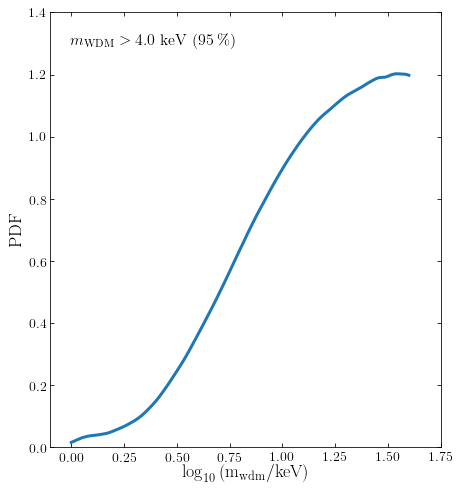

In [8]:
tol_tr_hi=0.3
tol_tr_med=0.2
tol_tr_lo=0.1
    

tol_le_hi=0.3
tol_le_med=0.2
tol_le_lo=0.1

accepted_mwdm=[]

for ii in range(len(diff_le_lo)):
    if (diff_tr_hi[ii] < tol_tr_hi) and (diff_tr_med[ii] < tol_tr_med) and (diff_tr_lo[ii] < tol_tr_lo) and (diff_le_hi[ii] < tol_le_hi) and (diff_le_med[ii] < tol_le_med) and (diff_le_lo[ii] < tol_le_lo):
        
        accepted_mwdm.append(mwdm_all[ii])

print ("total = ",len(diff_le_lo))
print ("accepted = ",len(accepted_mwdm))
        
bovy_plot.bovy_print(axes_labelsize=18.,xtick_labelsize=14.,ytick_labelsize=14.)
figsize(7,8)
cmap= cm.plasma
#subplot(1,2,1)
plot_pdf(accepted_mwdm,dat_type='loguniform_mwdm',add_68peak_95up=False,add_95up=False,add_95low=True,kernel_width=0.75,label=r'',overplot=True)
xlabel(r'$\log_{10}\left(\mathrm{m_{wdm}/keV}\right)$')
ylabel(r'$\mathrm{PDF}$')
xlim(-0.1,1.75)
ylim(0.,1.4)

total =  9090000
accepted =  779


(0.0, 1.4)

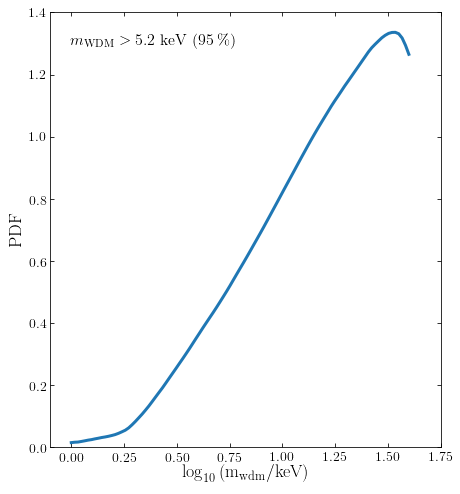

In [40]:
tol_tr_hi=0.2
tol_tr_med=0.1
tol_tr_lo=0.05
    

tol_le_hi=0.2
tol_le_med=0.1
tol_le_lo=0.05

accepted_mwdm=[]

for ii in range(len(diff_le_lo)):
    if (diff_tr_hi[ii] < tol_tr_hi) and (diff_tr_med[ii] < tol_tr_med) and (diff_tr_lo[ii] < tol_tr_lo) and (diff_le_hi[ii] < tol_le_hi) and (diff_le_med[ii] < tol_le_med) and (diff_le_lo[ii] < tol_le_lo):
        
        accepted_mwdm.append(mwdm_all[ii])

print ("total = ",len(diff_le_lo))
print ("accepted = ",len(accepted_mwdm))
        
bovy_plot.bovy_print(axes_labelsize=18.,xtick_labelsize=14.,ytick_labelsize=14.)
figsize(7,8)
cmap= cm.plasma
#subplot(1,2,1)
plot_pdf(accepted_mwdm,dat_type='loguniform_mwdm',add_68peak_95up=False,add_95up=False,add_95low=True,kernel_width=1.2,label=r'',overplot=True)
xlabel(r'$\log_{10}\left(\mathrm{m_{wdm}/keV}\right)$')
ylabel(r'$\mathrm{PDF}$')
xlim(-0.1,1.75)
ylim(0.,1.4)

total =  9090000
accepted =  22


(0.0, 2.4)

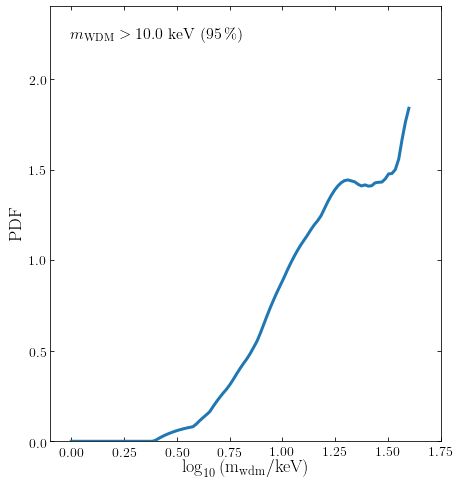

In [38]:
tol_tr_hi=0.1
tol_tr_med=0.05
tol_tr_lo=0.025
    

tol_le_hi=0.1
tol_le_med=0.05
tol_le_lo=0.025

accepted_mwdm=[]

for ii in range(len(diff_le_lo)):
    if (diff_tr_hi[ii] < tol_tr_hi) and (diff_tr_med[ii] < tol_tr_med) and (diff_tr_lo[ii] < tol_tr_lo) and (diff_le_hi[ii] < tol_le_hi) and (diff_le_med[ii] < tol_le_med) and (diff_le_lo[ii] < tol_le_lo):
        
        accepted_mwdm.append(mwdm_all[ii])

print ("total = ",len(diff_le_lo))
print ("accepted = ",len(accepted_mwdm))
        
bovy_plot.bovy_print(axes_labelsize=18.,xtick_labelsize=14.,ytick_labelsize=14.)
figsize(7,8)
cmap= cm.plasma
#subplot(1,2,1)
plot_pdf(accepted_mwdm,dat_type='loguniform_mwdm',add_68peak_95up=False,add_95up=False,add_95low=True,kernel_width=0.9,label=r'',overplot=True)
xlabel(r'$\log_{10}\left(\mathrm{m_{wdm}/keV}\right)$')
ylabel(r'$\mathrm{PDF}$')
xlim(-0.1,1.75)
ylim(0.,2.4)

In [34]:
cmap= cm.plasma

def color_from_colormap(val,cmap,cmin,cmax):
    va=[]
    for v in val:
        va.append(cmap((v-cmin)/(cmax-cmin)))
        
    return va

def add_discrete_colorbar_dens(vmin,vmax,clabel,ticks,save_figures=False):
    fig= pyplot.gcf()
    if save_figures:
        cbar_ax = fig.add_axes([0.775,0.135,0.05,0.815])
    else:
        fig.subplots_adjust(right=0.9)
        cbar_ax = fig.add_axes([0.925, 0.13, 0.075, 0.83])
    tcmap = matplotlib.colors.ListedColormap([cmap(f) for f in numpy.linspace(0.,1.,len(ticks))])
    dtick= (ticks[1]-ticks[0])
    sm = pyplot.cm.ScalarMappable(cmap=tcmap,norm=pyplot.Normalize(vmin=vmin-0.5*dtick,vmax=vmax+0.5*dtick))
    sm._A = []
    cbar= fig.colorbar(sm,cax=cbar_ax,use_gridspec=True,format=r'$%.1f$',ticks=ticks)
    cbar.set_label(clabel)
    return None

def add_colorbar(vmin,vmax,clabel,save_figures=False):
    fig= pyplot.gcf()
    if save_figures:
        cbar_ax = fig.add_axes([0.9,0.135,0.025,0.815])
    else:
        fig.subplots_adjust(right=0.95)
        cbar_ax = fig.add_axes([0.975, 0.13, 0.025, 0.83])
    sm = pyplot.cm.ScalarMappable(cmap=cmap,norm=pyplot.Normalize(vmin=vmin,vmax=vmax))
    sm._A = []
    cbar= fig.colorbar(sm,cax=cbar_ax,use_gridspec=True,format=r'$%.1f$')
    cbar.set_label(clabel)
    return None

mwdm_bins=np.linspace(0.5,50.5,51)

mwdm_binned=numpy.empty(len(mwdm_all))

for i in range(len(mwdm_all)):
    mwdm_binned[i]=numpy.digitize(10**(mwdm_all[i]),mwdm_bins)

    

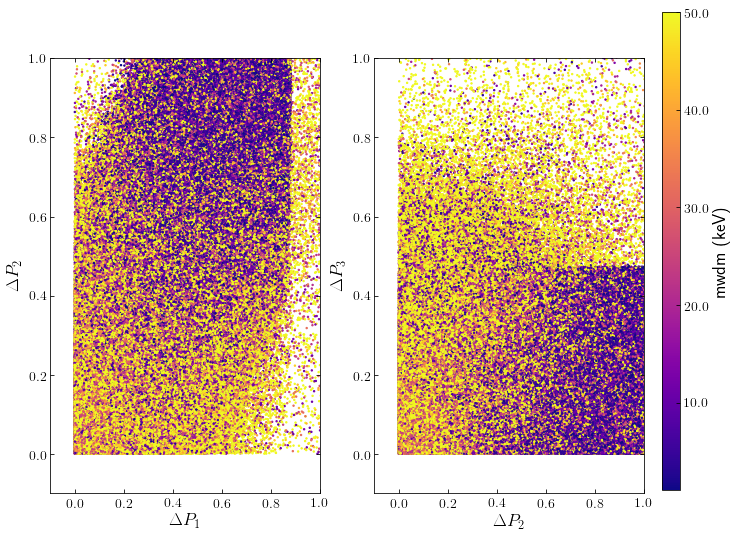

In [35]:
plt.figure(figsize=(10,8))

plt.subplot(1,2,1)
plt.scatter(diff_tr_hi,diff_tr_med,s=2,color=color_from_colormap(mwdm_binned,cmap,1.,20.),rasterized=True)  

plt.xlim(-0.1,1.)
plt.ylim(-0.1,1.)
plt.xlabel(r'$\Delta P_{1}$')
plt.ylabel(r'$\Delta P_{2}$')
#add_colorbar(1.,50.,r'mwdm (keV)')

plt.subplot(1,2,2)
plt.scatter(diff_tr_med,diff_tr_lo,s=2,color=color_from_colormap(mwdm_binned,cmap,1.,20.),rasterized=True)  

plt.xlim(-0.1,1.)
plt.ylim(-0.1,1.)
plt.xlabel(r'$\Delta P_{2}$')
plt.ylabel(r'$\Delta P_{3}$')
add_colorbar(1.,50.,r'mwdm (keV)')
#plt.savefig("Trailing_arm_mwdm_convergence_100K.pdf",bbox_inches='tight')
plt.show()